In [181]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

In [182]:
Customers = pd.read_csv("CUSTOMERS.csv")
Geo_location = pd.read_csv("GEO_LOCATION.csv")
Order_items = pd.read_csv("ORDER_ITEMS.csv")
Order_payment = pd.read_csv("ORDER_PAYMENTS.csv")
Order_review_rating = pd.read_csv("ORDER_REVIEW_RATINGS.csv")
Orders = pd.read_csv("ORDERS.csv")
Products = pd.read_csv("PRODUCTS.csv")
Sellers = pd.read_csv("SELLERS.csv")

In [183]:
Customers.customer_id.nunique()

99441

In [184]:
Customers.customer_unique_id.nunique()

96096

In [185]:
print("customer \n",Customers.dtypes)
print("\n")
print("Geo_location \n",Geo_location.dtypes)
print("\n")
print("Order_payment \n",Order_payment.dtypes)
print("\n")
print("Order_items \n",Order_items.dtypes)
print("\n")
print("Order_review_rating \n",Order_review_rating.dtypes)
print("\n")
print("Orders \n",Orders.dtypes)
print("\n")
print("Products \n",Products.dtypes)
print("\n")
print("Sellers \n",Sellers.dtypes)

customer 
 customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object


Geo_location 
 geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object


Order_payment 
 order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object


Order_items 
 order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object


Order_review_rating 
 review_id                  object
order_id                   object
review_score                int64
review_cr

### 1. Perform Detailed exploratory analysis

#### a. Define & calculate high level metrics like (Total Revenue, Total quantity, Total products, Total categories, Total sellers, Total locations, Total channels, Total payment methods etc…)

In [186]:
Total_revenue = round(Order_payment["payment_value"].sum(),2)
print(f"Total Revenue = {Total_revenue}")
Total_quatity =  Order_items["order_item_id"].sum()
print(f"Total Quantity = {Total_quatity}")
Total_products = Order_items["product_id"].nunique()
print(f"Total no of  Products = {Total_products}")
Total_categories = Products["product_category_name"].nunique()
print(f"Total no of categories = {Total_categories}")
Total_sellers = Sellers["seller_id"].nunique()
print(f"Total no of sellers = {Total_sellers}")
Total_locations = Geo_location["geolocation_zip_code_prefix"].nunique()
print(f"Total no of location = {Total_locations}")
Total_payment_methods = Order_payment["payment_type"].nunique()
print(f"Total payment method = {Total_payment_methods}")
No_of_state = Customers["customer_state"].nunique()
print(f"No of state with customers = {No_of_state}")
avg_installments = round(Order_payment["payment_installments"].mean())
print(f"Average no of installments = {avg_installments}")
avg_review_score = round(Order_review_rating["review_score"].mean(),2)
print(f"Average review score = {avg_review_score}")


Total Revenue = 16008872.12
Total Quantity = 134936
Total no of  Products = 32951
Total no of categories = 71
Total no of sellers = 3095
Total no of location = 19015
Total payment method = 5
No of state with customers = 20
Average no of installments = 3
Average review score = 4.07


#### b. Understanding how many new customers acquired every month

In [187]:
Orders_orders_item = Order_items.merge(Orders, on = "order_id", how = "left")
Orders_orders_item_payment = Orders_orders_item.merge(Order_payment, on = "order_id", how = "left")
Orders_orders_item_payment_prod = Orders_orders_item_payment.merge(Products, on = "product_id", how = "left")
Orders_orders_item_payment_prod_review = Orders_orders_item_payment_prod.merge(Order_review_rating, on = "order_id", how = "left")
Orders_orders_item_payment_prod_review_cust = Orders_orders_item_payment_prod_review.merge(Customers,on = "customer_id", how = "left")


In [188]:
# creating month column from order purchase date
Orders_orders_item_payment_prod_review_cust["order_purchase_timestamp"] = pd.to_datetime(Orders_orders_item_payment_prod_review_cust["order_purchase_timestamp"])
Orders_orders_item_payment_prod_review_cust["month"] = Orders_orders_item_payment_prod_review_cust["order_purchase_timestamp"].dt.month_name()


unique_cust = Orders_orders_item_payment_prod_review_cust[["customer_unique_id","month"]].drop_duplicates(subset = "customer_unique_id" )
new_cust = unique_cust.groupby("month")["customer_unique_id"].count()
new_cust


month
April         9055
August       10426
December      5448
February      8087
January       7721
July          9934
June          9075
March         9516
May          10177
November      7207
October       4699
September     4075
Name: customer_unique_id, dtype: int64

#### c. Understand the retention of customers on month on month basis


In [189]:
uniuqe_id = Orders_orders_item_payment_prod_review_cust.groupby(["month","customer_unique_id"])["customer_unique_id"].nunique()
new_tabele = Orders_orders_item_payment_prod_review_cust.merge(unique_cust, on = "customer_unique_id", how = "left")

new_tabele.rename(columns = { "month_x" : "month", "month_y" : "first_order_month"},inplace = True)
repeated_cust = new_tabele[new_tabele["first_order_month"] != new_tabele["month"]]
retention_cust = repeated_cust.groupby("month")["customer_unique_id"].count()
retention_cust


month
April        236
August       302
December     156
February     221
January      195
July         238
June         247
March        216
May          264
November     183
October      153
September    124
Name: customer_unique_id, dtype: int64

#### d. How the revenues from existing/new customers on month on month basis

In [190]:
month_revenue = Orders_orders_item_payment_prod_review_cust.groupby("month")["price"].sum().sort_values(ascending = False)
month_revenue 


month
May          1581926.26
August       1490758.50
July         1464308.34
March        1427707.11
April        1424340.98
June         1366920.50
February     1151791.05
January      1123596.81
November     1055072.10
December      773733.81
October       748926.23
September     665879.54
Name: price, dtype: float64

#### e. Understand the trends/seasonality of sales, quantity by category, location, month, week, day, time, channel, payment method etc…, 

In [191]:
#  Understand the trends/seasonality of sales to quantity by category, location, month

cat_quantity = Orders_orders_item_payment_prod_review_cust.groupby("product_category_name")["order_id"].count().sort_values(ascending = False)
cat_quantity_max = cat_quantity.head(10)
cat_quantity_min = cat_quantity.tail(10)
print(f"top 10 category \n {cat_quantity_max}")
print("\n")
print(f"bottom 10 category \n {cat_quantity_min}")

top 10 category 
 product_category_name
Bed_Bath_Table           11990
Health_Beauty            10033
Sports_Leisure            9005
Furniture_Decor           8833
Computers_Accessories     8151
Housewares                7380
Watches_Gifts             6213
Telephony                 4726
Garden_Tools              4590
Auto                      4400
Name: order_id, dtype: int64


bottom 10 category 
 product_category_name
Music                        40
Diapers_And_Hygiene          39
Flowers                      33
Fashion_Sport                31
Home_Comfort_2               31
Arts_And_Craftmanship        24
La_Cuisine                   16
Cds_Dvds_Musicals            14
Fashion_Childrens_Clothes     8
Security_And_Services         2
Name: order_id, dtype: int64


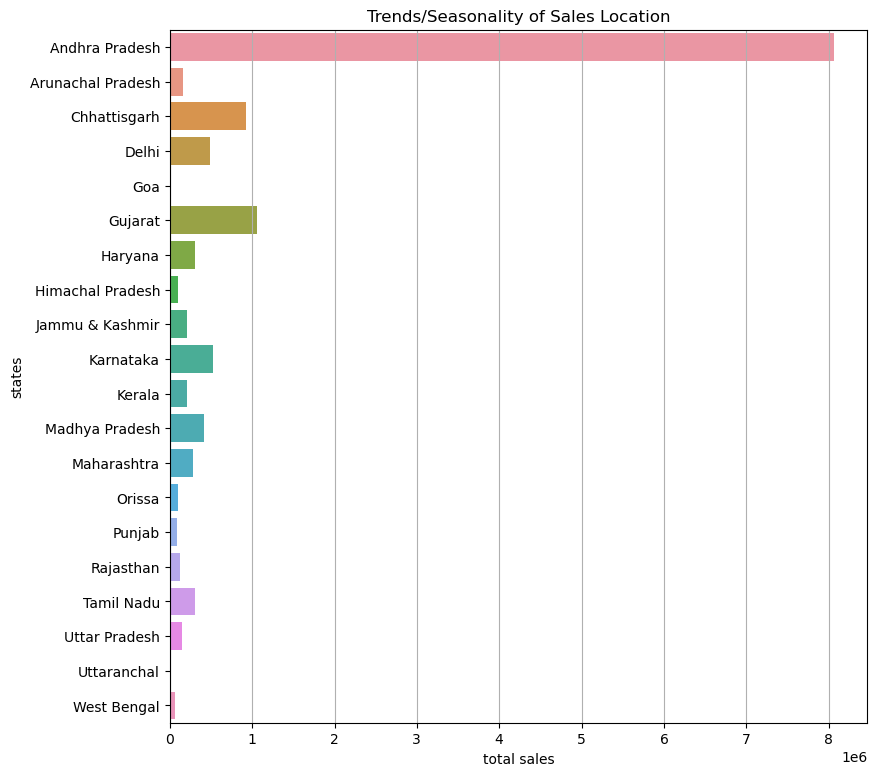

In [192]:
#  Understand the trends/seasonality of sales by  location,
Ordered_product_cust = Orders_orders_item.merge(Customers, on = "customer_id" , how = "left")
Ordered_product_cust= Orders_orders_item.merge(Customers, on = "customer_id" , how = "left")
cust_location = Ordered_product_cust.groupby("customer_state")["price"].sum()


# Plot the results using a bar plot

plt.figure(figsize = (9,9))
sns.barplot(x= cust_location.values, y = cust_location.index)
plt.xlabel("total sales")
plt.ylabel("states")
plt.title("Trends/Seasonality of Sales Location")
plt.grid(True,axis="x")
plt.show()


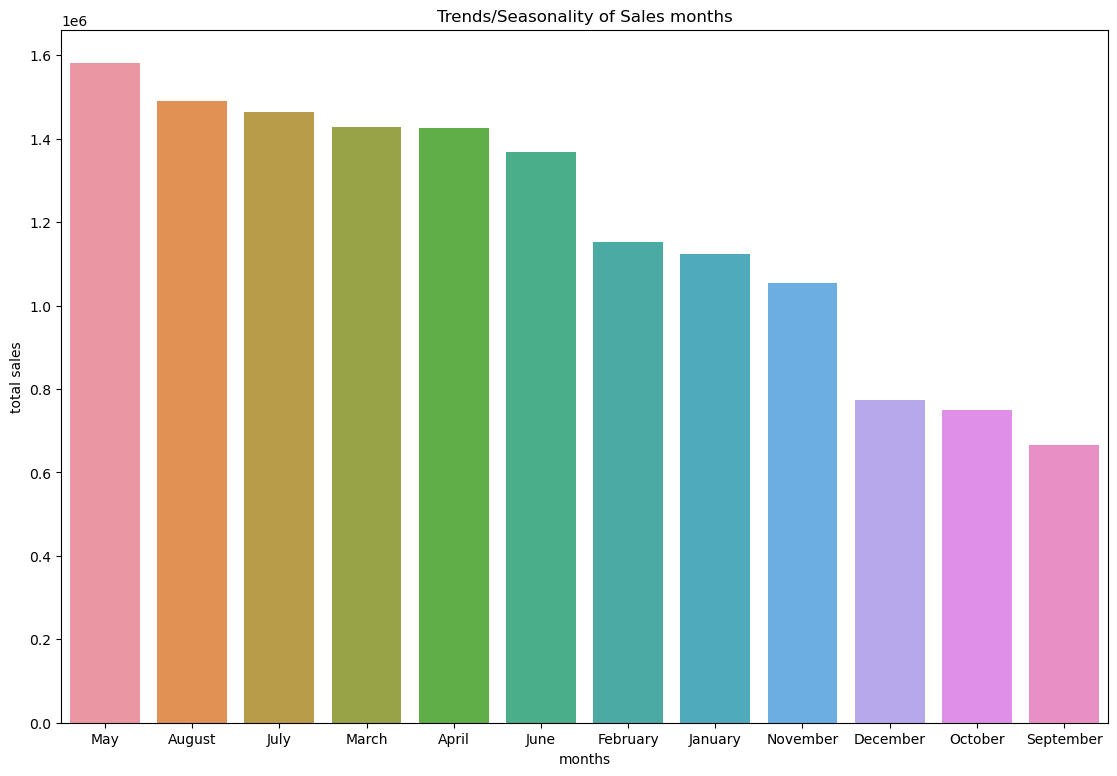

In [193]:
#  Understand the trends/seasonality of sales by  month,
month_sales = Orders_orders_item_payment_prod_review_cust.groupby("month")["price"].sum().sort_values(ascending = False)
                                                                              
plt.figure(figsize = (13.5,9))
sns.barplot(y= month_sales.values, x = month_sales.index)
plt.xlabel("months")
plt.ylabel("total sales")
plt.title("Trends/Seasonality of Sales months")

plt.show()


In [194]:
#  Understand the trends/seasonality of sales by  week,
Orders_orders_item_payment_prod_review_cust["week"] = Orders_orders_item_payment_prod_review_cust["order_purchase_timestamp"].dt.isocalendar().week
week_sale = Orders_orders_item_payment_prod_review_cust.groupby("week")["price"].sum().sort_values(ascending = False)
week_sale_top_10 = week_sale.head(10)
print(f"top 10 week number interms of sales : \n {week_sale_top_10}")


top 10 week number interms of sales : 
 week
19    430480.65
47    426480.18
32    426111.42
31    413343.98
20    400089.87
33    393500.42
30    374594.62
29    365463.73
18    361837.41
16    351452.66
Name: price, dtype: float64


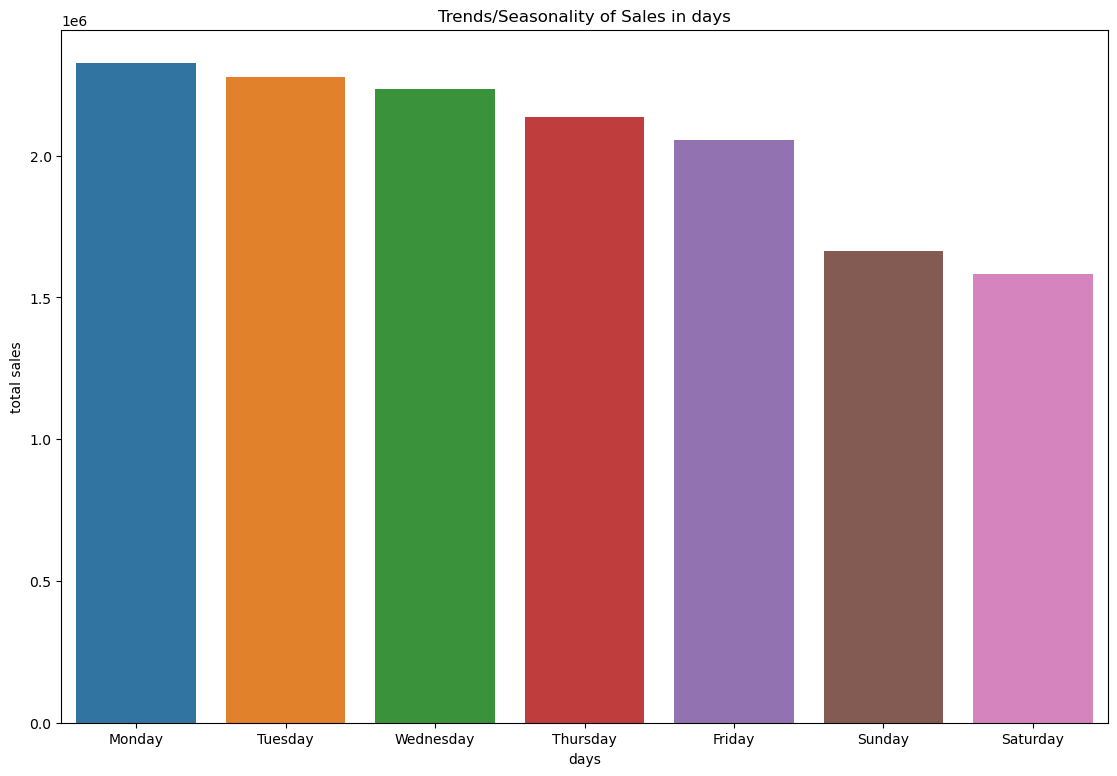

In [195]:
#  Understand the trends/seasonality of sales by  day,
Orders_orders_item_payment_prod_review_cust["day"] = Orders_orders_item_payment_prod_review_cust["order_purchase_timestamp"].dt.day_name()
week_sale = Orders_orders_item_payment_prod_review_cust.groupby("day")["price"].sum().sort_values(ascending = False)
plt.figure(figsize = (13.5,9))
sns.barplot(y= week_sale.values, x = week_sale.index)
plt.xlabel("days")
plt.ylabel("total sales")

plt.title("Trends/Seasonality of Sales in days")
plt.show()

Top selling hour is 14


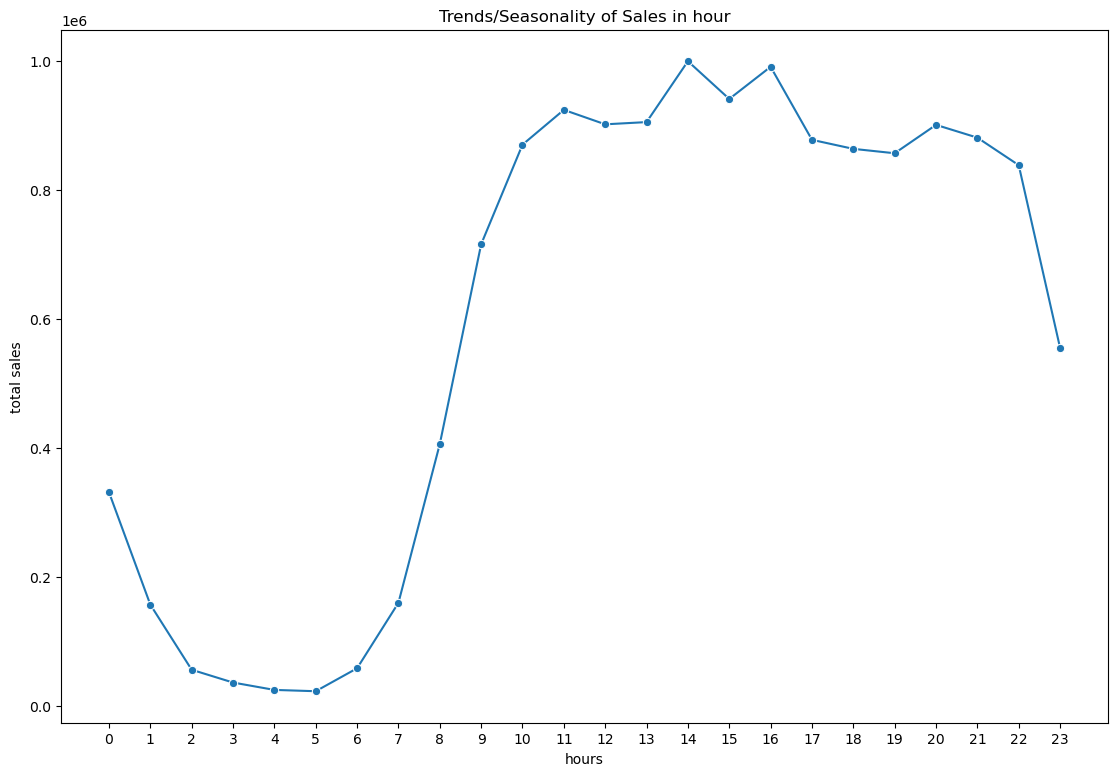

In [196]:
#  Understand the trends/seasonality of sales by  time,
Orders_orders_item_payment_prod_review_cust["hour"] = Orders_orders_item_payment_prod_review_cust["order_purchase_timestamp"].dt.hour
hour_sale = Orders_orders_item_payment_prod_review_cust.groupby("hour")["price"].sum().sort_values(ascending = False)
print(f"Top selling hour is {hour_sale.index[0]}")
plt.figure(figsize = (13.5,9))
sns.lineplot(y= hour_sale.values, x = hour_sale.index,data=hour_sale, marker="o")
plt.xlabel("hours")
plt.ylabel("total sales")
plt.xticks(hour_sale.index)
plt.title("Trends/Seasonality of Sales in hour")
plt.show()

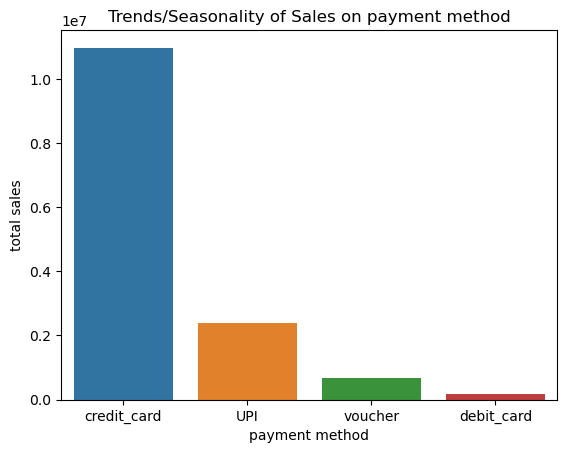

In [197]:
#  Understand the trends/seasonality of sales by  month,
Orders_orders_item_payment = Orders_orders_item.merge(Order_payment , on = "order_id" , how = "left")
payment_method = Orders_orders_item_payment.groupby("payment_type")["price"].sum().sort_values(ascending = False)

sns.barplot(y= payment_method.values, x = payment_method.index)
plt.xlabel("payment method")
plt.ylabel("total sales")
plt.title("Trends/Seasonality of Sales on payment method")
plt.show()

#### f. Popular Products by month, seller, state, category.


In [198]:
# popular product  id by different seller
popular_pdt_seller = Orders_orders_item_payment_prod_review_cust.groupby(["seller_id","product_id"])["product_id"].count()
popular_pdt_seller = popular_pdt_seller.reset_index(name="count")
popular_pdt_seller = popular_pdt_seller.sort_values(by=["count"],ascending = False)
popular_pdt_seller = popular_pdt_seller.groupby("seller_id").head(1)
popular_pdt_seller.reset_index(drop = True, inplace = True)
popular_pdt_seller = popular_pdt_seller[["seller_id","product_id"]]
print("popular product id based on different seller")
print("\n")
popular_pdt_seller

popular product id based on different seller




,seller_id,product_id
0,955fee9216a65b617aa5c0531780ce60,aca2eb7d00ea1a7b8ebd4e68314663af
1,4a3ca9315b744ce9f8e9374361493884,99a4788cb24856965c36a24e339b6058
2,1f50f920176fa81dab994f9023523100,422879e10f46682990de24d770e7f83d
3,a1043bafd471dff536d0c462352beb48,d1c427060a0f73f6b889a5c7c61f2ac4
4,cc419e0650a3c5ba77189a1882b7556a,154e7e31ebfa092203795c972e5804a6
...,...,...
3090,70ee69419916dc13e3aed619061f996c,dedb5adefe63796ce6edd624d0ebd8a8
3091,70f7e8018e3d46c748c92f026aa2585a,8141daa1ca889b50094987ed7858337e
3092,713e3a23ca5e47786eb6f0d99f94cfac,3fcd8dfe610c62edfb51de2630cd9ef4
3093,712efd3b68f9686dc856b84abd0f21ae,4466f429e81266e99d1935267aa13329


In [199]:
# popular product by month

popular_pdt_month = Orders_orders_item_payment_prod_review_cust.groupby(["month","product_id"])["order_id"].count().reset_index()
popular_pdt_month = popular_pdt_month.sort_values(by = "order_id", ascending = False)
popular_pdt_month = popular_pdt_month.groupby("month").head(1)
popular_pdt_month.reset_index(drop = True, inplace = True)
print("popular product id based on different month")
print("\n")
print(popular_pdt_month[["month","product_id"]])

popular product id based on different month


        month                        product_id
0     January  aca2eb7d00ea1a7b8ebd4e68314663af
1         May  53b36df67ebb7c41585e8d54d6772e08
2    November  422879e10f46682990de24d770e7f83d
3       April  aca2eb7d00ea1a7b8ebd4e68314663af
4        June  99a4788cb24856965c36a24e339b6058
5      August  e7cc48a9daff5436f63d3aad9426f28b
6    February  3dd2a17168ec895c781a9191c1e95ad7
7        July  99a4788cb24856965c36a24e339b6058
8       March  aca2eb7d00ea1a7b8ebd4e68314663af
9    December  422879e10f46682990de24d770e7f83d
10    October  422879e10f46682990de24d770e7f83d
11  September  0554911df28fda9fd668ce5ba5949695


In [200]:
Orders_orders_item_payment_prod_cust = Orders_orders_item_payment_prod.merge(Customers , on = "customer_id" , how = "left")
# popular product by different state
popular_pdt_state = Orders_orders_item_payment_prod_cust.groupby(["customer_state","product_id"])["order_id"].count().reset_index()
popular_pdt_state = popular_pdt_state.sort_values(by = "order_id", ascending = False)
popular_pdt_state = popular_pdt_state.groupby("customer_state").head(1)
popular_pdt_state.reset_index(drop = True, inplace = True)
print("popular product id based on different state")
print("\n")
print(popular_pdt_state[["customer_state","product_id"]])


popular product id based on different state


       customer_state                        product_id
0      Andhra Pradesh  aca2eb7d00ea1a7b8ebd4e68314663af
1             Gujarat  aca2eb7d00ea1a7b8ebd4e68314663af
2        Chhattisgarh  422879e10f46682990de24d770e7f83d
3      Madhya Pradesh  d1c427060a0f73f6b889a5c7c61f2ac4
4           Karnataka  422879e10f46682990de24d770e7f83d
5               Delhi  53759a2ecddad2bb87a079a1f1519f73
6             Haryana  35afc973633aaeb6b877ff57b2793310
7     Jammu & Kashmir  89b190a046022486c635022524a974a8
8              Kerala  aca2eb7d00ea1a7b8ebd4e68314663af
9         Maharashtra  99a4788cb24856965c36a24e339b6058
10         Tamil Nadu  b532349fe46b38fbc7bb3914c1bdae07
11  Arunachal Pradesh  03e1c946c0ddfc58724ff262aef08dff
12             Punjab  60ee9861f35c13d4a3a2bc10e86bb05b
13      Uttar Pradesh  3dd2a17168ec895c781a9191c1e95ad7
14          Rajasthan  3dd2a17168ec895c781a9191c1e95ad7
15             Orissa  aca2eb7d00ea1a7b8ebd4e68314663af
16

In [201]:
# popular product by categories
popular_pdt_cat = Orders_orders_item_payment_prod.groupby(["product_category_name","product_id"])["order_id"].count().reset_index()
popular_pdt_cat = popular_pdt_cat.sort_values(by = "order_id", ascending = False)
popular_pdt_cat = popular_pdt_cat.groupby("product_category_name").head(1)
popular_pdt_cat.reset_index(drop = True, inplace = True)
print("popular product id based on different categories")
print("\n")
print(popular_pdt_cat[["product_category_name","product_id"]])


popular product id based on different categories


        product_category_name                        product_id
0             Furniture_Decor  aca2eb7d00ea1a7b8ebd4e68314663af
1              Bed_Bath_Table  99a4788cb24856965c36a24e339b6058
2                Garden_Tools  422879e10f46682990de24d770e7f83d
3       Computers_Accessories  d1c427060a0f73f6b889a5c7c61f2ac4
4               Watches_Gifts  53b36df67ebb7c41585e8d54d6772e08
..                        ...                               ...
66              Fashion_Sport  e8f7d2639ff8caa8b86e5973295898b7
67                      Music  2848023ffcfb063bb7aa0d0c447bd116
68                 La_Cuisine  33900d427fa4bd3f509cdacda72e84a3
69  Fashion_Childrens_Clothes  57bdf3098169cccdb62221bd3e089cbd
70      Security_And_Services  8db75af9aed3315374db44d7860e25da

[71 rows x 2 columns]


#### g. Popular categories by state, month

In [202]:
Orders_orders_item_payment_prod_cust = Orders_orders_item_payment_prod.merge(Customers , on = "customer_id" , how = "left")
# popular product by different state
popular_pdt_state = Orders_orders_item_payment_prod_cust.groupby(["customer_state","product_category_name"])["order_id"].count().reset_index()
popular_pdt_state = popular_pdt_state.sort_values(by = "order_id", ascending = False)
popular_pdt_state = popular_pdt_state.groupby("customer_state").head(1)
popular_pdt_state.reset_index(drop = True, inplace = True)
print("popular categories based on different state")
print("\n")
print(popular_pdt_state[["customer_state","product_category_name"]])


popular categories based on different state


       customer_state            product_category_name
0      Andhra Pradesh                   Bed_Bath_Table
1             Gujarat                   Bed_Bath_Table
2        Chhattisgarh                   Bed_Bath_Table
3           Karnataka                   Bed_Bath_Table
4      Madhya Pradesh                   Bed_Bath_Table
5               Delhi                    Health_Beauty
6             Haryana                   Bed_Bath_Table
7         Maharashtra                   Bed_Bath_Table
8          Tamil Nadu                   Bed_Bath_Table
9     Jammu & Kashmir                   Bed_Bath_Table
10             Kerala                   Bed_Bath_Table
11  Arunachal Pradesh                   Bed_Bath_Table
12      Uttar Pradesh                    Health_Beauty
13          Rajasthan                   Sports_Leisure
14   Himachal Pradesh                   Bed_Bath_Table
15             Orissa                   Bed_Bath_Table
16             Punj

In [203]:
# popular product by month

popular_pdt_month = Orders_orders_item_payment_prod_review_cust.groupby(["month","product_category_name"])["order_id"].count().reset_index()
popular_pdt_month = popular_pdt_month.sort_values(by = "order_id", ascending = False)
popular_pdt_month = popular_pdt_month.groupby("month").head(1)
popular_pdt_month.reset_index(drop = True, inplace = True)
print("popular categories based on different month")
print("\n")
print(popular_pdt_month[["month","product_category_name"]])

popular categories based on different month


        month  product_category_name
0        July         Bed_Bath_Table
1      August         Bed_Bath_Table
2        June         Bed_Bath_Table
3         May         Bed_Bath_Table
4       March         Bed_Bath_Table
5    February  Computers_Accessories
6       April         Bed_Bath_Table
7    November         Bed_Bath_Table
8     January         Bed_Bath_Table
9     October         Bed_Bath_Table
10   December         Bed_Bath_Table
11  September         Bed_Bath_Table


#### h. List top 10 most expensive products sorted by price

In [204]:
top_10_expensive_products = Order_items.sort_values(by="price", ascending=False).head(10)
top_10_expensive_products = top_10_expensive_products[["product_id","price"]].reset_index(drop = True)
top_10_expensive_products

,product_id,price
0,489ae2aa008f021502940f251d4cce7f,6735.00
1,69c590f7ffc7bf8db97190b6cb6ed62e,6729.00
2,1bdf5e6731585cf01aa8169c7028d6ad,6499.00
3,a6492cc69376c469ab6f61d8f44de961,4799.00
4,c3ed642d592594bb648ff4a04cee2747,4690.00
5,259037a6a41845e455183f89c5035f18,4590.00
6,a1beef8f3992dbd4cd8726796aa69c53,4399.87
7,6cdf8fc1d741c76586d8b6b15e9eef30,4099.99
8,dd113cb02b2af9c8e5787e8f1f0722f6,4059.00
9,6902c1962dd19d540807d0ab8fade5c6,3999.90


### 2. Performing Customers/sellers Segmentation

### a. Divide the customers into groups based on the revenue generated

In [205]:
grouped = Orders_orders_item_payment_prod_review_cust.groupby(["customer_unique_id"])["payment_value"].sum().reset_index()
grouped.rename(columns = {"payment_value" : "Total_revenue"}, inplace = True)
cut_label = ["low revenue","mid revenue","high revenue"]
grouped["revenue_group"] = pd.qcut(grouped["Total_revenue"],q =[0, 0.33, 0.67, 1],labels = cut_label)
grouped


,customer_unique_id,Total_revenue,revenue_group
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,mid revenue
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,low revenue
2,0000f46a3911fa3c0805444483337064,86.22,mid revenue
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,low revenue
4,0004aac84e0df4da2b147fca70cf8255,196.89,high revenue
...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84,high revenue
95416,fffea47cd6d3cc0a88bd621562a9d061,84.58,mid revenue
95417,ffff371b4d645b6ecea244b27531430a,112.46,mid revenue
95418,ffff5962728ec6157033ef9805bacc48,133.69,mid revenue


#### b. Divide the sellers into groups based on the revenue generated

In [206]:
order_order_item = Order_items.merge(Orders, on = "order_id" , how = "left")
order_order_item_pay = order_order_item.merge(Order_payment, on = "order_id" , how = "left")
grouped = order_order_item_pay.groupby(["seller_id"])["payment_value"].sum().reset_index()
grouped.rename(columns = {"payment_value" : "Total_revenue"}, inplace = True)
cut_label = ["low revenue","mid revenue","high revenue"]
grouped["revenue_group"] = pd.qcut(grouped["Total_revenue"],q =[0, 0.33, 0.67, 1],labels = cut_label)
grouped

,seller_id,Total_revenue,revenue_group
0,0015a82c2db000af6aaaf3ae2ecb0532,2748.06,mid revenue
1,001cca7ae9ae17fb1caed9dfb1094831,48349.22,high revenue
2,001e6ad469a905060d959994f1b41e4f,267.94,low revenue
3,002100f778ceb8431b7a1020ff7ab48f,2445.64,mid revenue
4,003554e2dce176b5555353e4f3555ac8,139.38,low revenue
...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,79.52,low revenue
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,3607.52,high revenue
3092,ffeee66ac5d5a62fe688b9d26f83f534,2259.55,mid revenue
3093,fffd5413c0700ac820c7069d66d98c89,12834.27,high revenue


#### 3. Cross-Selling (Which products are selling together)

In [207]:

# Group order items by order ID
order_items_grouped = Order_items.groupby('order_id')['product_id'].apply(list)

# Get all combinations of 2 products that were bought together in each transaction
all_combinations = [comb for order in order_items_grouped for comb in combinations(order, 2)]

# Count the number of times each product combination appears across all transactions
combination_counts = dict(Counter(all_combinations))

# Sort the product combinations in descending order of frequency and select the top 10 combinations
top_10_combinations = sorted(combination_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_combinations

[(('422879e10f46682990de24d770e7f83d', '422879e10f46682990de24d770e7f83d'),
  279),
 (('ee3d532c8a438679776d222e997606b3', 'ee3d532c8a438679776d222e997606b3'),
  195),
 (('9571759451b1d780ee7c15012ea109d4', '9571759451b1d780ee7c15012ea109d4'),
  190),
 (('a62e25e09e05e6faf31d90c6ec1aa3d1', 'a62e25e09e05e6faf31d90c6ec1aa3d1'),
  141),
 (('368c6c730842d78016ad823897a372db', '368c6c730842d78016ad823897a372db'),
  139),
 (('b532349fe46b38fbc7bb3914c1bdae07', 'b532349fe46b38fbc7bb3914c1bdae07'),
  134),
 (('d5991653e037ccb7af6ed7d94246b249', 'd5991653e037ccb7af6ed7d94246b249'),
  123),
 (('53759a2ecddad2bb87a079a1f1519f73', '53759a2ecddad2bb87a079a1f1519f73'),
  119),
 (('89b190a046022486c635022524a974a8', '89b190a046022486c635022524a974a8'),
  115),
 (('aca2eb7d00ea1a7b8ebd4e68314663af', 'aca2eb7d00ea1a7b8ebd4e68314663af'),
  111)]

### 4. Payment Behaviour


#### a. How customers are paying?


In [208]:
Orders_orders_item_payment.dropna(inplace = True)
Orders_orders_item_payment[Orders_orders_item_payment["payment_type"].isna()]
payment_method = Orders_orders_item_payment.groupby("payment_type")["order_id"].count()
print(f" customers are paying through :  \n {payment_method}")

 customers are paying through :  
 payment_type
UPI            22347
credit_card    84895
debit_card      1653
voucher         6123
Name: order_id, dtype: int64


#### b. Which payment channels are used by most customers?

In [209]:
payment_method = Orders_orders_item_payment.groupby("payment_type").agg({'payment_value': ['count', 'sum']})
total_payment = payment_method["payment_value"]["count"].sum()
payment_method["percentage"] = round((payment_method["payment_value"]["count"]/total_payment)*100,2)
print(f" customers are paying through :  \n {payment_method}")

 customers are paying through :  
              payment_value              percentage
                     count          sum           
payment_type                                      
UPI                  22347   3940999.14      19.43
credit_card          84895  15189911.87      73.81
debit_card            1653    246373.27       1.44
voucher               6123    396110.42       5.32



### 5. Customer satisfaction towards category & product


#### a. Which categories (top 10) are maximum rated & minimum rated?


In [210]:
Orders_orders_item_payment_prod_review = Orders_orders_item_payment_prod.merge(Order_review_rating, on = "order_id"	,how = "left")
max_rated_cat = Orders_orders_item_payment_prod_review.groupby("product_category_name")["review_score"].mean().sort_values(ascending = False)
max_rated_cat = max_rated_cat.head(10)
min_rated_cat = Orders_orders_item_payment_prod_review.groupby("product_category_name")["review_score"].mean().sort_values()
min_rated_cat = min_rated_cat.head(10)
print(f"maximum rated categories are \n {round(max_rated_cat,2)}")
print("\n")
print(f"minumum rated categories are \n {round(min_rated_cat,2)}")

maximum rated categories are 
 product_category_name
Cds_Dvds_Musicals                        4.64
Fashion_Childrens_Clothes                4.50
Books_General_Interest                   4.43
Books_Imported                           4.42
Books_Technical                          4.35
Costruction_Tools_Tools                  4.33
Small_Appliances_Home_Oven_And_Coffee    4.32
Food_Drink                               4.31
Luggage_Accessories                      4.29
Fashion_Sport                            4.26
Name: review_score, dtype: float64


minumum rated categories are 
 product_category_name
Security_And_Services                2.50
Diapers_And_Hygiene                  3.26
Home_Comfort_2                       3.39
Office_Furniture                     3.52
Fashion_Male_Clothing                3.53
Fixed_Telephony                      3.66
Fashio_Female_Clothing               3.78
Furniture_Mattress_And_Upholstery    3.80
Audio                                3.82
Construction_Tools_

#### b. Which products (top10) are maximum rated & minimum rated?


In [211]:
Orders_orders_item_payment_prod_review = Orders_orders_item_payment_prod.merge(Order_review_rating, on = "order_id"	,how = "left")
max_rated_cat = Orders_orders_item_payment_prod_review.groupby("product_id")["review_score"].mean().sort_values(ascending = False)
max_rated_cat = max_rated_cat.head(10)
min_rated_cat = Orders_orders_item_payment_prod_review.groupby("product_id")["review_score"].mean().sort_values()
min_rated_cat = min_rated_cat.head(10)
print(f"maximum rated product are \n {round(max_rated_cat,2)}")
print("\n")
print(f"minumum rated product are \n {round(min_rated_cat,2)}")

maximum rated product are 
 product_id
00066f42aeeb9f3007548bb9d3f33c38    5.0
86743ff92eee3d16b7df59cddd583b8c    5.0
868ceb027ab706a4dee42e2220006b85    5.0
868969d3a93aeeab7bfcd4fc3d3d65de    5.0
868766ed2172644fdd977d6bd395a107    5.0
8684bd8f93b4f4038d07188a23811e93    5.0
867c96d2bb67aba6500a4c509cf76072    5.0
867b820367ec206b38a357f2c12454b7    5.0
867901d7e8488fb97f1fb538c09d476e    5.0
865bfa00c1dad8f4146d3c2765f051ca    5.0
Name: review_score, dtype: float64


minumum rated product are 
 product_id
592cc6634d2c783d297effc0b828bc37    1.0
8c4456c061013adccb1ba4cbce2d0365    1.0
28c8150eb44ec8106c8f061afd9c3e9f    1.0
28c95d7653177449fd4b6fc7adb63ce9    1.0
28d6d6a10ceb0636ae572e7efafef612    1.0
28d7da9ebe96bfda54aed060b68b23a1    1.0
8c35dc99b37ba51780800ba049ed3616    1.0
c43704bc45a1f1a58de5d2b5ba0b0d12    1.0
8c0c5d88d9ec2bc8e02395bda8ea52f2    1.0
28fe66c8a81afe9be7829f40a5fae9ee    1.0
Name: review_score, dtype: float64


#### c. Average rating by location, seller, product, category, month etc.

In [212]:
#average rating by cities

average_top_rat_city = Orders_orders_item_payment_prod_review_cust.groupby("customer_city")["review_score"].mean().sort_values(ascending = False)
average_top_rat_city = average_top_rat_city.head(10)
average_min_rat_city = Orders_orders_item_payment_prod_review_cust.groupby("customer_city")["review_score"].mean().sort_values(ascending = True)
average_min_rat_city = average_min_rat_city.head(10)
print(f"maximum rated cities are \n {round(average_top_rat_city,2)}")
print("\n")
print(f"minumum rated cities are \n {round(average_min_rat_city,2)}")


maximum rated cities are 
 customer_city
Ghagga                  5.0
Guru Har Sahai          5.0
Gursahaiganj            5.0
Singoli                 5.0
Naranapuram             5.0
Singrauli               5.0
Gummidipoondi           5.0
Guma                    5.0
Periyanaickenpalayam    5.0
Sirauli                 5.0
Name: review_score, dtype: float64


minumum rated cities are 
 customer_city
Dhandera       1.0
Lucknow        1.0
Saiyad Raja    1.0
Uttar Goara    1.0
Sahapur        1.0
Mahu Kalan     1.0
Koch Bihar     1.0
Shoranur       1.0
Ettayapuram    1.0
Rewa           1.0
Name: review_score, dtype: float64


In [213]:
# average rating by states
average_top_rat_state = Orders_orders_item_payment_prod_review_cust.groupby("customer_state")["review_score"].mean().sort_values(ascending = False)
average_top_rat_state = average_top_rat_state.head(10)
average_min_rat_state = Orders_orders_item_payment_prod_review_cust.groupby("customer_state")["review_score"].mean().sort_values(ascending = True)
average_min_rat_state = average_min_rat_state.head(10)
print(f"maximum rated state are \n {round(average_top_rat_state,2)}")
print("\n")
print(f"minumum rated state are \n {round(average_min_rat_state,2)}")


maximum rated state are 
 customer_state
Goa              4.80
Punjab           4.17
Uttar Pradesh    4.13
Haryana          4.12
Tamil Nadu       4.11
Rajasthan        4.10
Maharashtra      4.09
Orissa           4.09
Kerala           4.05
Gujarat          4.04
Name: review_score, dtype: float64


minumum rated state are 
 customer_state
Uttaranchal          3.72
Himachal Pradesh     3.99
Andhra Pradesh       4.00
Madhya Pradesh       4.00
Jammu & Kashmir      4.00
West Bengal          4.00
Karnataka            4.02
Arunachal Pradesh    4.02
Delhi                4.03
Chhattisgarh         4.03
Name: review_score, dtype: float64


In [214]:
# average rating by seller
average_top_rat_seller = Orders_orders_item_payment_prod_review_cust.groupby("seller_id")["review_score"].mean().sort_values(ascending = False)
average_top_rat_seller = average_top_rat_seller.head(10)
average_min_rat_seller = Orders_orders_item_payment_prod_review_cust.groupby("seller_id")["review_score"].mean().sort_values(ascending = True)
average_min_rat_seller = average_min_rat_seller.head(10)
print(f"maximum rated seller are \n {round(average_top_rat_seller,2)}")
print("\n")
print(f"minumum rated seller are \n {round(average_min_rat_state,2)}")

maximum rated seller are 
 seller_id
c18309219e789960add0b2255ca4b091    5.0
2075d8cd4dd63ff12df0749a5866bb06    5.0
40ec8ab6cdafbcc4f544da38c67da39a    5.0
4125d9385a25e82d2f72d3a0fd55bc3f    5.0
417a1e6c7321084d2a0ae0d023cfad93    5.0
41958cbd3335433c8740300e8cd600d5    5.0
41e0fa5761c886a630994a55c12087e7    5.0
422be4cc81a457fdb46f47edeb968ae5    5.0
c963a25b8671419c6ce9eebe8fd03218    5.0
eb9267cccc90f1b49c8d2f9887c7dd97    5.0
Name: review_score, dtype: float64


minumum rated seller are 
 customer_state
Uttaranchal          3.72
Himachal Pradesh     3.99
Andhra Pradesh       4.00
Madhya Pradesh       4.00
Jammu & Kashmir      4.00
West Bengal          4.00
Karnataka            4.02
Arunachal Pradesh    4.02
Delhi                4.03
Chhattisgarh         4.03
Name: review_score, dtype: float64


In [215]:
# average rating by month
average_rat_month = Orders_orders_item_payment_prod_review_cust.groupby("month")["review_score"].mean().sort_values(ascending = False)
print(f"average rating for month are \n {round(average_rat_month,2)}")
Orders_orders_item_payment_prod_review_cust["month"]

average rating for month are 
 month
August       4.20
July         4.17
June         4.16
September    4.12
May          4.12
April        4.04
October      4.01
January      3.94
December     3.93
November     3.83
February     3.79
March        3.78
Name: review_score, dtype: float64


0         September
1             April
2           January
3            August
4          February
            ...    
118313        April
118314         July
118315      October
118316       August
118317         June
Name: month, Length: 118318, dtype: object

In [216]:
# average rating by month
average_rat_hour = Orders_orders_item_payment_prod_review_cust.groupby("hour")["review_score"].mean().sort_values(ascending = False)
print(f"average rating for  hour are \n {round(average_rat_hour,2)}")


average rating for  hour are 
 hour
22    4.09
8     4.07
7     4.06
3     4.04
20    4.04
13    4.03
14    4.03
21    4.03
17    4.03
16    4.03
9     4.02
23    4.02
19    4.02
10    4.00
11    4.00
12    3.98
5     3.98
15    3.98
18    3.95
1     3.95
0     3.92
6     3.91
4     3.87
2     3.85
Name: review_score, dtype: float64


In [217]:
# average rating by day
average_rat_day = Orders_orders_item_payment_prod_review_cust.groupby("day")["review_score"].mean().sort_values(ascending = False)
print(f"average rating for days are \n {round(average_rat_day,2)}")

average rating for days are 
 day
Wednesday    4.05
Tuesday      4.04
Monday       4.03
Sunday       4.01
Thursday     4.00
Saturday     3.99
Friday       3.97
Name: review_score, dtype: float64
